# Double Debiased Machine Learning (part 2)

## Recap

In the [previous part of this blog post](https://towardsdatascience.com/eb767a59975b), we have seen how pre-testing can distort inference, i.e., how selecting control variables depending on their statistical significance results in wrong confidence intervals for the variable of interest.

In particular, we have explored the example of a firm that is interested in testing the effectiveness of an a campaign. 

The following [**Directed Acyclic Graph (DAG)**](https://towardsdatascience.com/b63dc69e3d8c) summarizes the data generating process. 

```mermaid
flowchart LR
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

D((ad spend))
Z((past sales))
Y((sales))

D --> Y
Z -- ??? --> Y
Z --> D

class D,Y included;
class Z excluded;

linkStyle 0 stroke:#00ff00,stroke-width:4px;
```

I import the data generating process `dgp_tbd()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/src/dgp.py) and some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/src/utils.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_pretest

df = dgp_pretest().generate_data()
df.head()

,ads,sales,past_sales
0,16.719800,19.196620,6.624345
1,7.732222,9.287491,4.388244
2,10.923469,11.816906,4.471828
3,8.457062,9.024376,3.927031
4,13.085146,12.814823,5.865408


We have data on $1000$ different markets, in which we observe current `sales`, the amount spent in `advertisement` and `past sales`. 

We want to understand `ads` spending is effective in increasing `sales`. One possibility is to regress the latter on the former, using the following regression model, also called the **short model**.

$$
\text{sales} = \alpha \cdot \text{ads} + \varepsilon
$$

Should we also include `past sales` in the regression? Then the regression model would be the following, also called **long model**.

$$
\text{sales} = \alpha \cdot \text{ads} + \beta \cdot \text{past sales} + \varepsilon
$$

Since we are not sure whether to condition the analysis on `past sales`, we could **let the data decide**: we could run the second regression and, if the effect of `past sales`, $\beta$, is statistically significant, we are good with the long model, otherwise we run the short model.

The problem with this procedure is that it introduces a bias that is called **regularization or pre-test** bias. Usually this bias is sufficiently small so that the coefficient estimate is still unbiased. However, it is big enough to

Is there a solution? Yes!

## Post-Double Selection

The solution is called **post-double selection**. The method was first introduced in [Belloni, Chernozhukov, Hansen (2014)](https://academic.oup.com/restud/article-abstract/81/2/608/1523757). They assume the following data generating process:

$$
y = \alpha D + \beta Z + \varepsilon
\newline
X = \gamma Z + u
$$

Consider a regression $Y$ (`sales` in our example) on $D$ (`ads`) and $X$ (`past_sales`). $D$ is the 1-dimensional variable of interest, $X$ is a (potentially) high-dimensional set of control variables. Post-double selection consists in the following procedure.

1. **First Stage** selection: regress $D$ on $X$. Select the statistically significant variables in the set $S_{FS} \subseteq X$
2. **Reduced Form** selection: lasso $Y$ on $X$. Select the statistically significant variables in the set $S_{RF} \subseteq X$
3. Regress $Y$ on $D$ and the **union** of the selected variables in the first two steps, $S_{FS} \cup S_{RF}$

The authors show that this procedure produces confidence intervals for the variable of interest $D$ that have the correct coverage, i.e. the correct probability of type 1 error.

**Note**: this procedure is always less parsimonious, in terms of variable selection, than pre-testing. In fact, we still select all the variables we would have selected with pre-testing but, additionally, in the first stage we might select additional variables.

**Note (2)**: the terms *first stage* and *reduced form* come from the [intrumental variables](https://en.wikipedia.org/wiki/Instrumental_variables_estimation) literature in econometrics. Indeed, the first application of post-double selection was to select instrumental variables in [Belloni, Chen, Chernozhukov, Hansen (2012)](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA9626). 

### Intuition

The idea behind post-double selection is: bound the [omitted variables bias](https://towardsdatascience.com/344ac1477699). In this setting, we can express omitted variable bias as

$$
\text{OVB} = \beta \delta \qquad \text{ where } \qquad \beta := \frac{Cov(X, Y)}{Var(X)}, \quad \delta := \frac{Cov(D, X)}{Var(D)}
$$

As we can see, omitted variable bias comes from the product of 2 quantities related to the omitted variable $X$:

1. Its partial correlation with the outcome, $\beta$
2. Its partial correlation with the variable of interest, $\delta$

With pre-testing, we ensure that the partial correlation between $X$ the outcome $Y$, $\beta$, is small. In fact, we omit $Z$ when we shouldn't (i.e. we commit a type 2 error) rarely. What do *small* and *rarely* mean?

When we are selecting a variable because of its significance, we ensure that it dimension is smaller than $\frac{c}{\sqrt{n}$ for some number $c$, where $n$ is the sample size. 

Therefore, with pre-testing, we ensure that, no matter what the value of $delta$ is, the dimension of the bias is smaller than $\frac{c}{\sqrt{n}$ which means that it converges to zero for sufficiently large $n$. This is why the pre-testing estimator is still unbiased.

However, in order for our confidence intervals to have the right coverage, this is **not enough**. In practice, we need the bias to converge to zero faster than $1 / \sqrt{n}$. 

What is the **intuition**? The [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) tells us that for large $n$ the sample mean converges to a normal distribution with mean $\mu$ and standard deviation $\sigma / \sqrt{n}$, where $\mu$ and $\sigma$ are the true mean and standard deviation of the distribution. The standard deviation (of the estimator) is critical for building confidence intervals. Therefore, if the bias is not sensibly smaller than the standard deviation of the estimator, the confidence intervals are going to be wrong.

In our omitted variable bias case, we want $| \beta_0 \gamma_0 | = o \left( \frac{1}{\sqrt{n}} \right)$.  Post-double selection guarantees that 

- *Reduced form* selection (pre-testing): any "missing" variable $j$ has $|\beta_j| \leq \frac{c}{\sqrt{n}}$
- *First stage* selection (additional): any "missing" variable $j$ has $|\delta_j| \leq \frac{c}{\sqrt{n}}$


As a consequence, as long as the number of omitted variables is finite, the omitted variable bias is 

### Application

Let's now go back to our example and test the post-double selection procedure. In practice, we want to do the following:

1. **First Stage** selection: regress `ads` on `past_sales`. Check if `past_sales` is statistically significant
2. **Reduced Form** selection: regress `sales` on `past_sales`. Check if `past_sales` is statistically significant
3. Regress $Y$ on $D$ and include `past_sales` if it was significant in *either* one of the two previous regressions

I update the `pre_test` function from the first part of the post to compute also the post-double selection estimator.

In [3]:
def pre_test(d='ads', y='sales', x='past_sales', K=1000, **kwargs):
    
    # Init
    alphas = pd.DataFrame({'Long': np.zeros(K), 
             'Short': np.zeros(K), 
             'Pre-test': np.zeros(K),
             'Post-double': np.zeros(K)})

    # Loop over simulations
    for k in range(K):
        
        # Generate data
        df = dgp_pretest().generate_data(seed=k, **kwargs)
        
        # Compute coefficients
        alphas['Long'][k] = smf.ols(f'{y} ~ {d} + {x}', df).fit().params[1]
        alphas['Short'][k] = smf.ols(f'{y} ~ {d}', df).fit().params[1]
    
        # Compute significance of beta and gamma
        p_value_ydx = smf.ols(f'{y} ~ {d} + {x}', df).fit().pvalues[2]
        p_value_dx = smf.ols(f'{d} ~ {x}', df).fit().pvalues[1]
        
        # Select pre-test specification based on regression of y on d and x
        if p_value_ydx<0.05:
            alphas['Pre-test'][k] = alphas['Long'][k]
        else:
            alphas['Pre-test'][k] = alphas['Short'][k]
            
        # Select post-double specification based on regression of y on d and x
        if p_value_ydx<0.05 or p_value_dx<0.05:
            alphas['Post-double'][k] = alphas['Long'][k]
        else:
            alphas['Post-double'][k] = alphas['Short'][k]
    
    return alphas

In [4]:
alphas = pre_test()

We can now plot the distributions (over simulations) of the estimated coefficients.

In [5]:
def plot_alphas(alphas, true_alpha):
    
    # Init plot
    K = len(alphas.columns)
    fig, axes = plt.subplots(1, K, figsize=(4*K, 5), sharey=True, sharex=True)

    # Make one plot for each set of coefficients
    for i, key in enumerate(alphas.columns):
        axes[i].hist(alphas[key].values, bins=30, lw=.1, color=f'C{int(i==3)}')
        axes[i].set_title(key)
        axes[i].axvline(true_alpha, c='r', ls='--')
        legend_text = [r'$\alpha=%.0f$' % true_alpha, r'$\hat \alpha=%.4f$' % np.mean(alphas[key])]
        axes[i].legend(legend_text, prop={'size': 10}, loc='upper right')

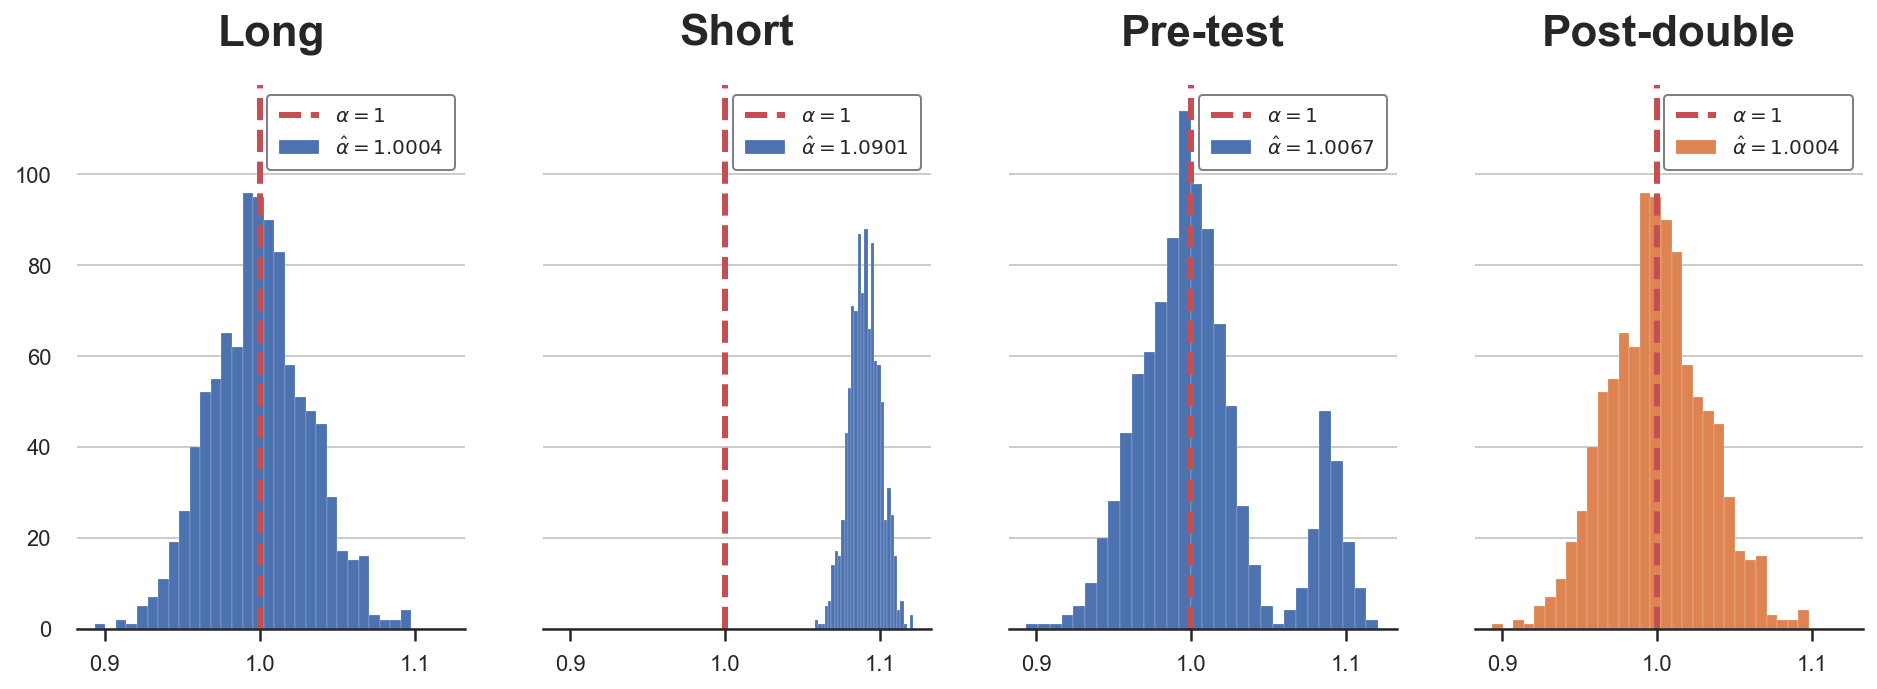

In [6]:
plot_alphas(alphas, true_alpha=1)

TBD

### Double-checks

In the last post, we ran some simulations in order to check when pre-testing bias emerges. We saw that pre-testing is a problem for

- Small sample sizes $n$
- Intermediate values of $\beta$
- Whenever the value of $\beta$ depends on the sample size

Let's check that post-double selection removes regularization bias in **all** the previous cases.

First, let's simulate the distribution of the post-double selection estimator $\hat \alpha_{post-double}$ for different sample sizes.

In [7]:
Ns = [100,300,1000,3000]
alphas = {f'N = {n:.0f}':  pre_test(N=n) for n in Ns}

In [8]:
def compare_alphas(alphas, true_alpha):
    
    # Init plot
    fig, axes = plt.subplots(1, len(alphas), figsize=(4*len(alphas), 5), sharey=True, sharex=True)

    # Make one plot for each set of coefficients
    for i, key in enumerate(alphas.keys()):
        axes[i].hist(alphas[key]['Pre-test'], bins=30, lw=.1, alpha=0.5)
        axes[i].hist(alphas[key]['Post-double'], bins=30, lw=.1, alpha=0.5)
        axes[i].set_title(key)
        axes[i].axvline(true_alpha, c='r', ls='--')
        axes[i].legend([r'$\alpha=%.0f$' % true_alpha, 'Pre-test', 'Post-double'], prop={'size': 10}, loc='upper right')

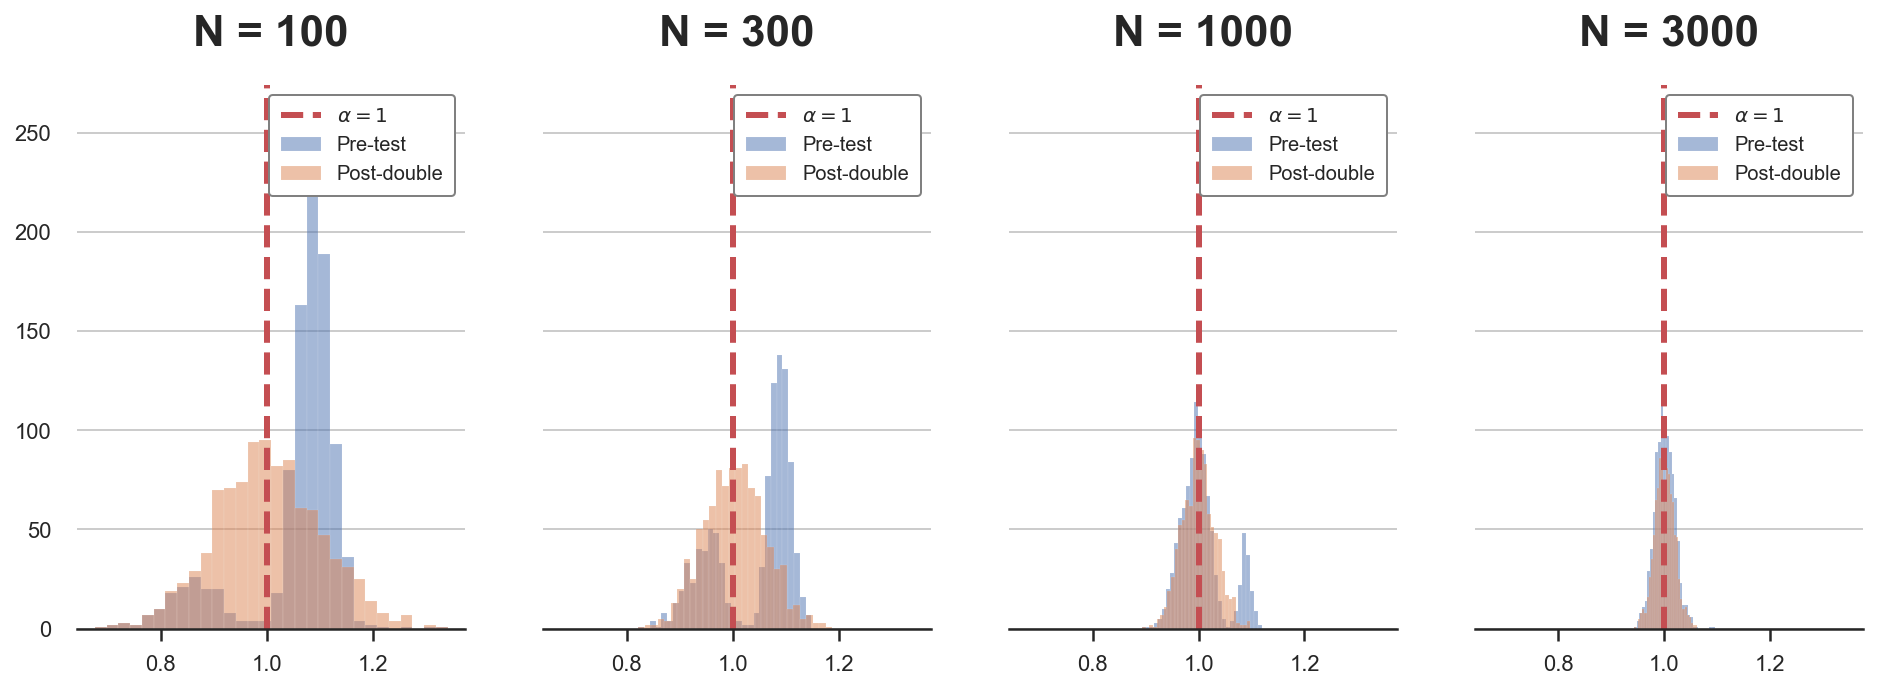

In [9]:
compare_alphas(alphas, true_alpha=1)

For small samples, the distribution of the pre-testing estimator is not normal but rather bimodal. From the plots we can see that the post-double estimator is gaussian also in small sample sizes.

Now we repeat the same exercise, but for different values of $\beta$.

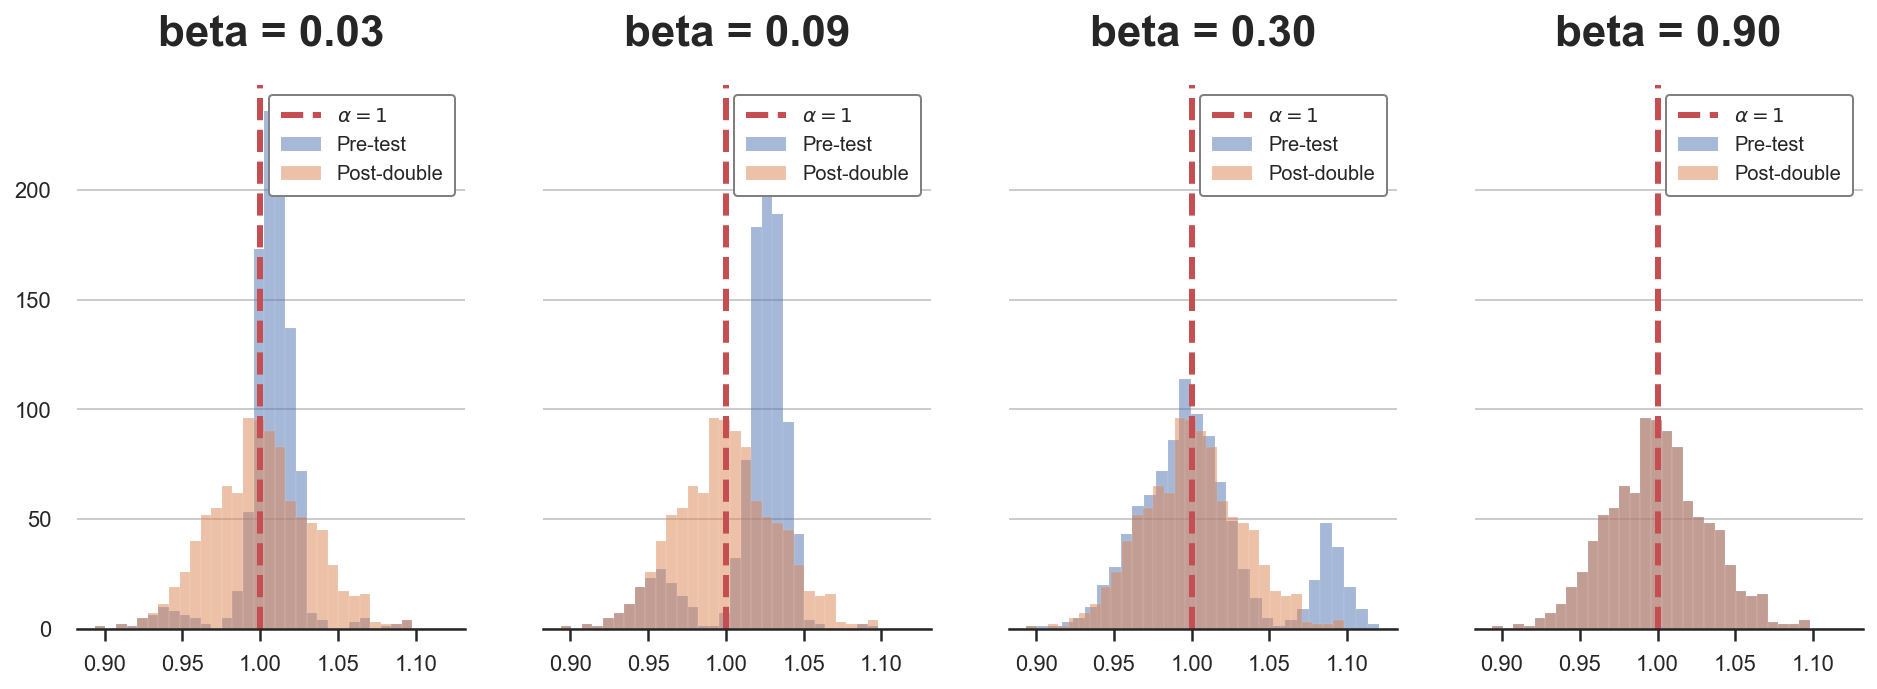

In [10]:
betas = 0.3 * np.array([0.1,0.3,1,3])
alphas = {f'beta = {b:.2f}': pre_test(b=b) for b in betas}
compare_alphas(alphas, true_alpha=1)

Again, the post-double selection estimator has a gaussian distribution irrespectively of the value of $\beta$, while he pre-testing estimator suffers from regularization bias.

For the last simulation, we change both the coefficient and the sample size at the same time.

In [ ]:
betas = 0.3 * 30 / np.sqrt(Ns)
alphas = {f'N = {n:.0f}':  pre_test(b=b, N=n) for n,b in zip(Ns,betas)}
compare_alphas(alphas, true_alpha=1)

Also in this last case, the post-double selection estimator performs well and inference is not distorted.

## Double Debiased Machine Learning



Consider the following partially linear model

$$
Y = \alpha D + g_0(X) + u \\
D = m_0(X) + v
$$

where $y$ is the outcome variable, $D$ is the treatment to interest and $X$ is a potentially high-dimensional set of controls.

### Naive approach

A naive approach to estimation of $\beta_0$ using ML methods would be, for example, to construct a sophisticated ML estimator $\alpha D + g_0(X)$ for learning the regression function $\beta_0 D$ + $g_0(X)$.

1. Split the sample in two: main sample and auxiliary sample
2. Use the auxiliary sample to estimate $\hat g_0(X)$
3. Use the main sample to compute the orthogonalized component of $Y$ on $X$: $\ \hat u = \left(Y_{i}-\hat{g}_{0}\left(X_{i}\right)\right)$ 
3. Use the main sample to estimate the residualized OLS estimator

$$
\hat \alpha = \left(\frac{1}{n} \sum_{i \in I} D_{i}^{2}\right)^{-1} \frac{1}{n} \sum_{i \in I} D_{i} \hat u_i
$$

This estimator is going to have two problems:

1. Slow rate of convergence, i.e. slower than $\sqrt(n)$
2. It will be biased because we are employing highdimensional regularized estimators (e.g. we are doing variable selection)

### Orthogonalization

Now consider a second construction that employs an orthogonalized formulation obtained by directly partialling out the effect of $X$ from $D$ to obtain the orthogonalized regressor $v = D − m_0(X)$.

1. Split the sample in two: main sample and auxiliary sample
2. Use the auxiliary sample to estimate $\hat g_0(X)$ from
    
    $$
    Y = \alpha D + g_0(X) + u \\
    $$


3. Use the auxiliary sample to estimate $\hat m_0(X)$ from

    $$
    D = m_0(X) + v
    $$


4. Use the main sample to compute the orthogonalized component of $D$ on $X$ as

    $$
    \hat v = D - \hat m_0(X)
    $$
    
    
5. Use the main sample to estimate the double-residualized OLS estimator as

    $$
    \alpha = \left(\frac{1}{n} \sum_{i \in I} \hat v_i D_{i} \right)^{-1} \frac{1}{n} \sum_{i \in I} \hat v_i \left( Y - \hat g_0(X) \right)
    $$


The estimator is unbiased but still has a lower rate of convergence because of sample splitting. The problem is solved by inverting the split sample, re-estimating the coefficient and averaging the two estimates. Note that this procedure is valid since the two estimates are independent by the sample splitting procedure.

## Conclusion

TBD

### References

[1] A. Belloni, D. Chen, V. Chernozhukov, C. Hansen, [Sparse Models and Methods for Optimal Instruments With an Application to Eminent Domain](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA9626) (2012), *Econometrica*.

[2] A. Belloni, V. Chernozhukov, C. Hansen, [Inference on treatment effects after selection among high-dimensional controls](https://academic.oup.com/restud/article-abstract/81/2/608/1523757) (2014), *The Review of Economic Studies*.

[3] V. Chernozhukov, D. Chetverikov, M. Demirer, E. Duflo, C. Hansen, W. Newey, J. Robins, [Double/debiased machine learning for treatment and structural parameters](https://academic.oup.com/ectj/article/21/1/C1/5056401) (2018), *The Econometrics Journal*.

### Related Articles

- [Double Debiased Machine Learning (part 1)](https://towardsdatascience.com/eb767a59975b)
- [Understanding Omitted Variable Bias](https://towardsdatascience.com/344ac1477699)
- [Understanding The Frisch-Waugh-Lovell Theorem](https://towardsdatascience.com/59f801eb3299)
- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/ddml.ipynb